# Week 3 Assignment

In [1]:
import numpy as np
import pandas as pd
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

## Getting the Postal code table from Wikipedia

* First, we retrieve the table:

In [2]:
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]
df

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


* Now, we get rid of the postal codes that don't gave a Borough assigned:

In [3]:
df = df[df["Borough"] != "Not assigned"]
df

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


* Now, we use a for loop to check if there's any Neighbourhood with the value "Not assigned". If we find any, we change its value for the name of the Borough:

In [4]:
for i in range(0,df.shape[0]):
    if df.iloc[i,2] == "Not assigned":
        df.iloc[i,2] = df.iloc[i,1]

* Finally, as requested, we check the shape of our dataframe to see the number of rows:

In [5]:
df.shape

(103, 3)

## Getting the neighbourhood's coordinates

* Now, we import the associated coordinates

In [6]:
df_coord = pd.read_csv("https://cocl.us/Geospatial_data")
df_coord

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


* We use the pandas.merge method to join the two dataframes:

In [7]:
total_df = pd.merge(df,df_coord,how="left",on="Postal Code")
total_df

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


## Displaying the obtained neighbourhood's locations in the map

* We see how many different boroughs there are:

In [8]:
total_df["Borough"].value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East York            5
East Toronto         5
York                 5
Mississauga          1
Name: Borough, dtype: int64

* We could consider only the boroughs with the word "Toronto" in them:

In [9]:
downtown_df = total_df[total_df["Borough"] == "Downtown Toronto"]
central_df = total_df[total_df["Borough"] == "Central Toronto"]
west_df = total_df[total_df["Borough"] == "West Toronto"]
east_df = total_df[total_df["Borough"] == "East Toronto"]

toronto_df = pd.merge(downtown_df,central_df,how="outer")
toronto_df = pd.merge(toronto_df,west_df,how="outer")
toronto_df = pd.merge(toronto_df,east_df,how="outer")
toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [10]:
toronto_df.shape

(39, 5)

* We get the coordinates for Toronto:

In [11]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


* We display the map of Toronto and markers in every neighbourhood. I chose to display every neighbourhood in the dataframe and __not only the ones containing "Toronto" in them__, because all those neighbourhoods are actually in Toronto:

In [66]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10.4)

# add markers to map
for lat, lng, borough, neighborhood in zip(total_df['Latitude'], total_df['Longitude'], total_df['Borough'], total_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

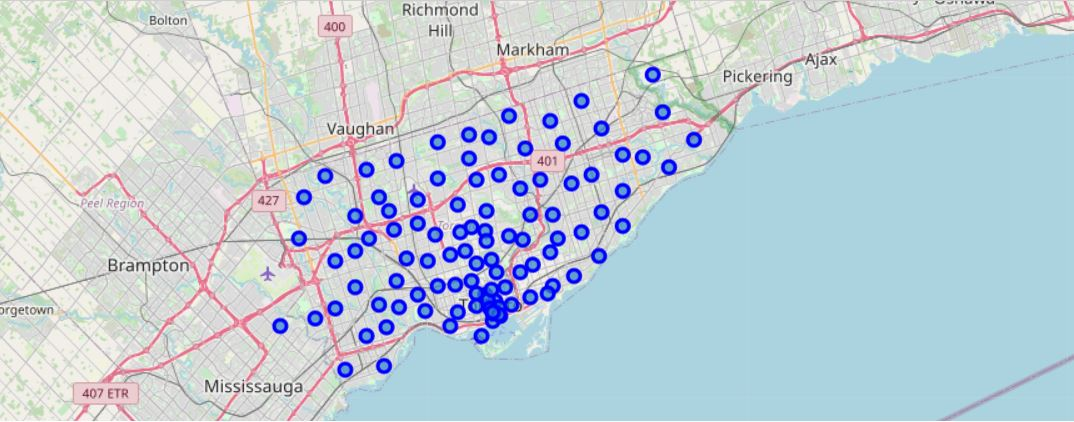

## Getting neighbourhood's venues information with Foursquare

* We define Foursquare Credentials and Version:

In [13]:
CLIENT_ID = 'LILSMXYXRKYBEDNGQQ4DSSPTZRL2HGZL2WBQXIYFBXSBIXZE' # your Foursquare ID
CLIENT_SECRET = 'CJHKNB2IQVISKA1E4NTE5CQULYFEYSCQ41SSBA0BJ2CKDSSE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: LILSMXYXRKYBEDNGQQ4DSSPTZRL2HGZL2WBQXIYFBXSBIXZE
CLIENT_SECRET:CJHKNB2IQVISKA1E4NTE5CQULYFEYSCQ41SSBA0BJ2CKDSSE


In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

* We define a function to repeat the same process to all the neighborhoods in Toronto:

In [15]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

* Now we run the above function on each neighborhood and create a new dataframe called *toronto_venues*:

In [17]:
toronto_venues = getNearbyVenues(names=total_df["Neighbourhood"],latitudes=total_df["Latitude"], longitudes=total_df["Longitude"])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

* We check how many venues we collected in total:

In [18]:
print(toronto_venues.shape)
toronto_venues.head()

(2140, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


* We group them by neighbourhood:

In [19]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
...,...,...,...,...,...,...
"Willowdale, Willowdale East",32,32,32,32,32,32
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,3,3,3,3,3,3


* We check how many unique categories there are:

In [20]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 267 uniques categories.


* We use one hot encoding for being able to process the data:

In [21]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
toronto_onehot.shape

(2140, 268)

* We group the venues by neighbourhood, adding up the amounts of venues of each category for a same neighbourhood:

In [23]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,"Willowdale, Willowdale East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.03125,0.0,0.0,0.0,0.0,0.0,0.0
93,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
94,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
95,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
toronto_grouped.shape

(97, 268)

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

* Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Latin American Restaurant,Skating Rink,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
1,"Alderwood, Long Branch",Pizza Place,Pharmacy,Coffee Shop,Sandwich Place,Pub,Dance Studio,Pool,Skating Rink,Gym,Donut Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Fried Chicken Joint,Shopping Mall,Bridal Shop,Sandwich Place,Diner,Middle Eastern Restaurant,Restaurant,Deli / Bodega
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Yoga Studio,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Restaurant,Pizza Place,Boutique,Juice Bar,Fast Food Restaurant,Butcher,Café


## Clustering the neighbourhoods:

* We cluster the neigbourhoods in 5 clusters, to follow the example shown in the lab:

In [33]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

* We create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood:

In [28]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = total_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighbourhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2.0,Park,Construction & Landscaping,Food & Drink Shop,Yoga Studio,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Pizza Place,French Restaurant,Coffee Shop,Portuguese Restaurant,Hockey Arena,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Bakery,Park,Pub,Theater,Café,Breakfast Spot,Event Space,Farmers Market,Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Clothing Store,Accessories Store,Furniture / Home Store,Coffee Shop,Miscellaneous Shop,Shoe Store,Boutique,Event Space,Vietnamese Restaurant,Women's Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.0,Coffee Shop,Diner,Yoga Studio,Park,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café


* The cluster labels were assigned as floats and not ints. We check them with the head() method:

In [35]:
toronto_merged["Cluster Labels"].head()

0    2.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: Cluster Labels, dtype: float64

* We use value_counts() to see all the distinct labels given to the clusters:

In [41]:
toronto_merged["Cluster Labels"].value_counts()

1.0    88
2.0     9
3.0     2
4.0     1
0.0     1
Name: Cluster Labels, dtype: int64

In [43]:
88+9+2+1+1

101

In [42]:
toronto_merged.shape

(103, 16)

* Adding them up, we notice that they don't add up to 103. So there are 2 venues that weren't assigned to a cluster. For the sake of simplicity, let's just remove them:

In [48]:
for i in range(0,toronto_merged.shape[0]):
    if toronto_merged.loc[i,"Cluster Labels"] not in ["0.0","1.0","2.0","3.0","4.0",0.0,1.0,2.0,3.0,4.0]:
        print(toronto_merged.loc[i,"Postal Code"])

M2L
M1X


In [49]:
clean1 = toronto_merged[toronto_merged["Postal Code"] != "M2L"]
clean1.shape

(102, 16)

In [50]:
clean2 = clean1[clean1["Postal Code"] != "M1X"]
clean2.shape

(101, 16)

In [56]:
toronto_merged = clean2

* Now, we transform the cluster labels to integers:

In [57]:
toronto_merged["Cluster Labels"].astype(int)

0      2
1      1
2      1
3      1
4      1
      ..
98     1
99     1
100    1
101    1
102    1
Name: Cluster Labels, Length: 101, dtype: int32

## Displaying the clusters in the map

In [65]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    u = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(u), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[u-1],
        fill=True,
        fill_color=rainbow[u-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

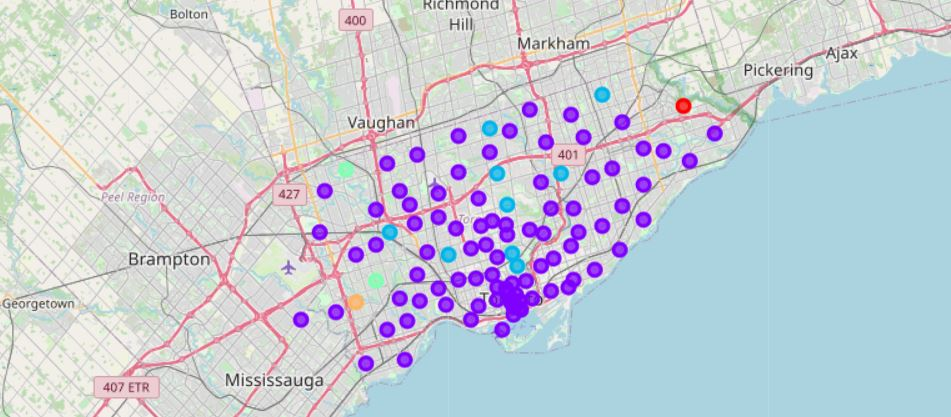